In [ ]:
import zipfile as zf
files = zf.ZipFile("101_ObjectCategories_test.zip", 'r')
files.extractall('101_ObjectCategories_test')

## 5-layer CNN

In [4]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 150


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set
train_datagen = ImageDataGenerator(rescale=1./255.)

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32
)
                                

# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Using TensorFlow backend.


Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


In [5]:

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(102, activation='softmax')
])



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
# Compile and fit model
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = cnn_model.fit(train_dataset,
             validation_data=val_dataset,
             epochs=50)

Epoch 1/50
212/212 [==============================] - 78s 369ms/step - loss: 3.4938 - acc: 0.2834 - val_loss: 2.8678 - val_acc: 0.3907
Epoch 2/50
212/212 [==============================] - 73s 346ms/step - loss: 2.5202 - acc: 0.4451 - val_loss: 2.4794 - val_acc: 0.4385
Epoch 3/50
212/212 [==============================] - 72s 340ms/step - loss: 2.0006 - acc: 0.5382 - val_loss: 2.2386 - val_acc: 0.4857
Epoch 4/50
212/212 [==============================] - 73s 343ms/step - loss: 1.5732 - acc: 0.6264 - val_loss: 2.0286 - val_acc: 0.5444
Epoch 5/50
212/212 [==============================] - 71s 337ms/step - loss: 1.1847 - acc: 0.7106 - val_loss: 1.9328 - val_acc: 0.5724
Epoch 6/50
212/212 [==============================] - 72s 337ms/step - loss: 0.8443 - acc: 0.7900 - val_loss: 1.9436 - val_acc: 0.5813
Epoch 7/50
212/212 [==============================] - 77s 363ms/step - loss: 0.5635 - acc: 0.8579 - val_loss: 2.1819 - val_acc: 0.5649
Epoch 8/50
212/212 [==============================] - 7

In [7]:
# Store model

cnn_model.save("clean_data.h5")

In [8]:
# Save history of model

import numpy as np
data_history_training = history.history

np.save('history_clean_data.npy', data_history_training)

In [9]:
# Evaluate model

from tensorflow import keras

reconstructed_model = keras.models.load_model("clean_data.h5")
reconstructed_model.evaluate(test_dataset)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
29/29 [==============================] - 6s 220ms/step - loss: 4.1139 - acc: 0.5702


[4.113873999694298, 0.5701559]

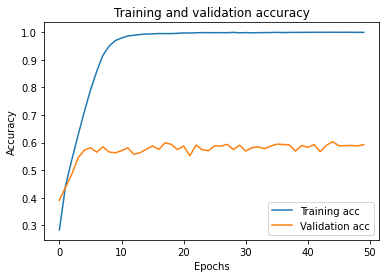

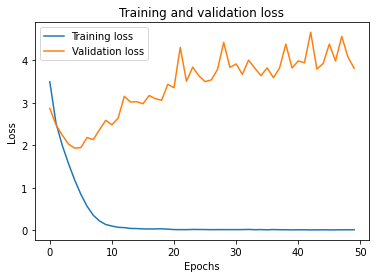

In [11]:
import numpy as np
reconstructed_history = np.load('history_clean_data.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history['acc']
val_acc = reconstructed_history['val_acc']
loss = reconstructed_history['loss']
val_loss = reconstructed_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


## 5-layer CNN with augmented inputs

In [1]:
# Image processing from local files

from keras.preprocessing.image import ImageDataGenerator
image_size = 150


# Define directory roots
train_root = './101_ObjectCategories_test/101_ObjectCategories/train'
val_root = './101_ObjectCategories_test/101_ObjectCategories/val'
test_root = './101_ObjectCategories_test/101_ObjectCategories/test'

# Generate training set
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  )

train_dataset = train_datagen.flow_from_directory(
    train_root,
    target_size=(image_size, image_size),
    batch_size=32    
)
                                

# Generate validation set   
val_datagen = ImageDataGenerator(rescale=1./255.)

val_dataset = val_datagen.flow_from_directory(
    val_root,
    target_size=(image_size, image_size),
    batch_size=32
)

# Generate test set
test_datagen = ImageDataGenerator(rescale=1./255.)

test_dataset = test_datagen.flow_from_directory(
    test_root,
    target_size=(image_size, image_size),
    batch_size=32,
)

total_length = len(train_dataset.filenames) + len(val_dataset.filenames) + len(test_dataset.filenames)
print("Train, in percentage (%) : ", len(train_dataset.filenames)/total_length * 100)
print("Val, in percentage (%) : ", len(val_dataset.filenames)/total_length * 100)
print("Test, in percentage (%) : ", len(test_dataset.filenames)/total_length * 100)

Using TensorFlow backend.


Found 6782 images belonging to 102 classes.
Found 1464 images belonging to 102 classes.
Found 898 images belonging to 102 classes.
Train, in percentage (%) :  74.16885389326335
Val, in percentage (%) :  16.010498687664043
Test, in percentage (%) :  9.820647419072616


In [3]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(102, activation='softmax')
])


#model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset,
             validation_data=val_dataset,
             epochs=100)

Epoch 1/100
212/212 [==============================] - 164s 773ms/step - loss: 3.9944 - acc: 0.1797 - val_loss: 3.5767 - val_acc: 0.2889
Epoch 2/100
212/212 [==============================] - 131s 618ms/step - loss: 3.5237 - acc: 0.2638 - val_loss: 3.1779 - val_acc: 0.3210
Epoch 3/100
212/212 [==============================] - 131s 620ms/step - loss: 3.2571 - acc: 0.3008 - val_loss: 3.0285 - val_acc: 0.3456
Epoch 4/100
212/212 [==============================] - 130s 611ms/step - loss: 3.0814 - acc: 0.3312 - val_loss: 2.8655 - val_acc: 0.3825
Epoch 5/100
212/212 [==============================] - 131s 618ms/step - loss: 2.9592 - acc: 0.3468 - val_loss: 2.7769 - val_acc: 0.3818
Epoch 6/100
212/212 [==============================] - 128s 605ms/step - loss: 2.8568 - acc: 0.3587 - val_loss: 2.6681 - val_acc: 0.4078
Epoch 7/100
212/212 [==============================] - 131s 618ms/step - loss: 2.7581 - acc: 0.3763 - val_loss: 2.5896 - val_acc: 0.4146
Epoch 8/100
212/212 [====================

In [4]:
# Store model

model.save("data_aug_no_shuffle.h5")

In [17]:
# Evaluate model

from tensorflow import keras

reconstructed_model = keras.models.load_model("data_aug_no_shuffle.h5")
reconstructed_model.evaluate(test_dataset)

29/29 [==============================] - 5s 161ms/step - loss: 2.3239 - acc: 0.5969


[2.3239405155181885, 0.596882]

In [12]:
# Save history of model

import numpy as np
data_history_training = history.history

np.save('history_augmenter.npy', data_history_training)
    

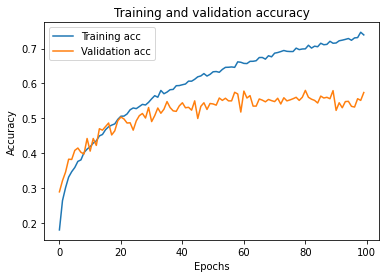

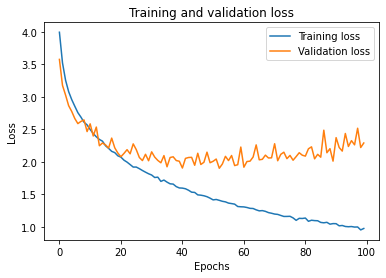

In [3]:
# Plot from stored history

import numpy as np
reconstructed_history = np.load('history_augmenter.npy',allow_pickle='TRUE').item()

import matplotlib.pyplot as plt

acc = reconstructed_history['acc']
val_acc = reconstructed_history['val_acc']
loss = reconstructed_history['loss']
val_loss = reconstructed_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.figure()
plt.savefig("test.eps", format='eps')

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

